In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import signal
import time

In [2]:
df=pd.read_csv('mnist_test.csv',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
image_arr=[]
label_arr=[]
for i in tqdm(range(len(df))):
    read=np.array(df.loc[i])
    label=read[0]
    image=read[1:]
    image=np.reshape(image,(28,28))
    image_arr.append(image)
    label_arr.append(label)
    
image_arr=np.array(image_arr)

100%|██████████| 10000/10000 [00:02<00:00, 4232.80it/s]


In [4]:
def sigmoid(z):
    return 1./(1+np.exp(-z))

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def convolve2D(filterDim,numFilters,image,W,b):
    imageDim=np.shape(image)[0]
    convDim=imageDim-filterDim+1 #assuming stride=1 and padding=0
    convolvedFeatures=np.zeros((convDim,convDim,numFilters))
    for filterNum in range(numFilters):
        convolvedImage=np.zeros((convDim,convDim))
        Filter=W[:,:,filterNum]
        Filter=np.squeeze(Filter)
        Feature=signal.convolve2d(image,Filter, 'valid')+b[filterNum]
        #activation
        convolvedImage=sigmoid(Feature)
        convolvedFeatures[:,:,filterNum]=convolvedImage
        
    return convolvedFeatures

def maxPool(poolDim,convolvedFeatures,maxPool):
    numFilters=np.shape(convolvedFeatures)[2]
    convolvedDim=np.shape(convolvedFeatures)[0]
    x=int(np.ceil(convolvedDim/poolDim))
    pooledFeatures=np.zeros((x,x,numFilters))
    for filterNum in range(numFilters):
        pFeatures=np.zeros((x,x))
        convFeatures=convolvedFeatures[:,:,filterNum]
        for i in range(x):
            p=(i*poolDim)
            for j in range(x):
                q=(j*poolDim)
                r=convFeatures[p:poolDim+p,q:poolDim+q]
                if maxPool:
                    pFeatures[i,j]=np.max(r)
                else:
                    pFeatures[i,j]=np.mean(r)
        
        pooledFeatures[:,:,filterNum]=pFeatures
    return pooledFeatures

def initCNNFeatures(imageDim,filterDim,numFilters,poolDim,numClasses):
    '''
    % Initialize parameters for a single set of conv-pooling laters followed by
    % fully connected layer
    % ---------------------------------------------------------------------------                           
    % Parameters:
    %  imageDim   -  height/width of image
    %  filterDim  -  dimension of convolutional filter                            
    %  numFilters -  number of convolutional filters
    %  poolDim    -  dimension of pooling area
    %  numClasses -  number of classes to predict%

    % Returns:
    %  Wc,Wd,bc,bd
    '''
    #Initialize parameters randomly based on layer sizes.
    assert filterDim < imageDim,'filterDim must be less that imageDim'
    Wc=1e-1*np.random.randn(int(filterDim),int(filterDim),numFilters)
    outDim=imageDim-filterDim+1 # dimension of convolved image
    
    assert outDim%poolDim==0,'poolDim must divide imageDim - filterDim + 1'
    # assume outDim is multiple of poolDim
    outDim = outDim/poolDim
    hiddenSize = (outDim**2)*numFilters
    r=np.sqrt(6)/np.sqrt(numClasses+hiddenSize+1)
    # choose weights uniformly from the interval [-r, r]
    Wd=np.random.rand(numClasses, int(hiddenSize))*2*r-r
    bc=np.zeros((numFilters,1))
    bd=np.zeros((numClasses,1))
    return [Wc,Wd,bc,bd]

In [5]:
imageDim = 28
numClasses = 10
filterDim = 9
numFilters = 20
poolDim = 2 

# Initialize network weights and params
print('Inititalising the Network')
[Wc,Wd,bc,bd] = initCNNFeatures(imageDim,filterDim,numFilters,poolDim,numClasses)

epochs=3
mom=0
alpha=1e-1
vel_Wc=np.zeros(np.shape(Wc))
vel_Wd=np.zeros(np.shape(Wd))
vel_bc=np.zeros(np.shape(bc))
vel_bd=np.zeros(np.shape(bd))

numImages=np.shape(image_arr)[0]
# Actual Training
for e in range(epochs):
    tic=time.time() # start timer
    print('epoch: %d'%e)
    for i in tqdm(range(numImages)):
        im=image_arr[i]/255 #normalization
        #print('Currently training:  Epoch: %d ; Sample: %d / %d\n'%(e,i,numImages))
        
        #### Convolution Layer ####
        convDim = imageDim-filterDim+1 # dimension of convolved output
        activations = np.zeros((convDim,convDim,numFilters))
        activations = convolve2D(filterDim, numFilters, im, Wc, bc)

        ####  Pooling Layer #### 
        outputDim = int(np.ceil((convDim)/poolDim)) # dimension of subsampled output
        activationsPooled1 = np.zeros((outputDim,outputDim,numFilters))
        activationsPooled1 = maxPool(poolDim,activations,True)

        ####  input to fully connected layer #### 
        actPool1_size=1
        for d in range(len(activationsPooled1.shape)):
            actPool1_size*=activationsPooled1.shape[d]
        activationsPooled = np.reshape(activationsPooled1,(1,actPool1_size))
        probs = np.zeros((numClasses,1))
        probs = softmax(np.dot(Wd,activationsPooled.T) + bd)
        
        
        
        # Calculate Gradients
        Wc_grad=np.zeros(np.shape(Wc));
        Wd_grad=np.zeros(np.shape(Wd));
        bc_grad=np.zeros(np.shape(bc));
        bd_grad=np.zeros(np.shape(bd));

        groundTruth =label_arr[i]
        deriv_1 = -(groundTruth - probs)

        Wd_grad = np.dot(deriv_1,activationsPooled)
        bd_grad = deriv_1

        deriv_2_pooled_sh = np.dot(Wd.T,deriv_1)

        deriv_2_pooled = np.reshape(deriv_2_pooled_sh,(outputDim,outputDim,numFilters))
        deriv_2_upsampled = np.zeros((convDim,convDim,numFilters))

        for filterNum in range(numFilters):
            aux3 = (1/(poolDim**2))*np.kron(np.squeeze(deriv_2_pooled[:,:,filterNum]),np.ones((poolDim,poolDim)))
            deriv_2_upsampled[:,:,filterNum] = np.multiply(np.multiply(aux3,activations[:,:,filterNum]),(1-activations[:,:,filterNum]))

            f_now = np.squeeze(deriv_2_upsampled[:,:,filterNum])
            noww = signal.convolve2d(im,np.squeeze(f_now),'valid')

            Wc_grad[:,:,filterNum] = np.squeeze(Wc_grad[:,:,filterNum]) + noww
            bc_grad[filterNum] = bc_grad[filterNum] + np.sum(f_now)
       

     
            #update weights along with momentum and learning rate
        vel_Wc  = np.dot(mom,vel_Wc) + np.dot(alpha , Wc_grad);
        Wc = Wc - vel_Wc;
        vel_Wd = np.dot(mom, vel_Wd) + np.dot(alpha , Wd_grad);
        Wd = Wd - vel_Wd;
        vel_bc = np.dot(mom, vel_bc) + np.dot(alpha , bc_grad);
        bc = bc -   vel_bc;
        vel_bd = np.dot(mom, vel_bd) + np.dot(alpha , bd_grad);
        bd = bd - vel_bd;   


    alpha = alpha/2.0;


    toc=time.time()
    print('...Done. Training took %.2f seconds\n' %(toc-tic))

#Visualize weights



  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
  0%|          | 5/10000 [00:00<03:48, 43.82it/s]

Inititalising the Network
epoch: 0


  0%|          | 4/10000 [00:00<04:43, 35.32it/s]

...Done. Training took 313.88 seconds

epoch: 1


  0%|          | 5/10000 [00:00<03:33, 46.77it/s]

...Done. Training took 317.49 seconds

epoch: 2


100%|██████████| 10000/10000 [04:50<00:00, 38.20it/s]

...Done. Training took 290.22 seconds



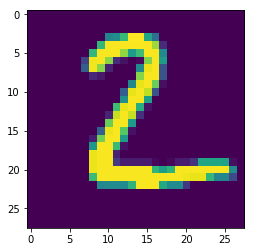

In [10]:
plt.imshow(image_arr[1])
plt.show()